In [1]:
pip install tqdm


In [2]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [4]:
# Function to check if the file exists
def is_valid_file(path):
    return os.path.exists(path)

In [5]:
# Define transforms for the training and testing data
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


In [6]:
# Define the data directory paths
train_dir = '/content/drive/My Drive/full_db/Train_final'
val_dir = '/content/drive/My Drive/full_db/Val_final'
test_dir = '/content/drive/My Drive/full_db/Test_final'

In [7]:
# Print the exact paths being checked
print(f"Checking path: {train_dir}")
print(f"Checking path: {val_dir}")
print(f"Checking path: {test_dir}")


Checking path: /content/drive/My Drive/full_db/Train_final
Checking path: /content/drive/My Drive/full_db/Val_final
Checking path: /content/drive/My Drive/full_db/Test_final


In [8]:
# Debug: Check if directories exist
print(f"Train directory exists: {os.path.exists(train_dir)}")
print(f"Validation directory exists: {os.path.exists(val_dir)}")
print(f"Test directory exists: {os.path.exists(test_dir)}")

Train directory exists: True
Validation directory exists: True
Test directory exists: True


In [9]:
train_data = datasets.ImageFolder(train_dir, transform=train_transforms, is_valid_file=is_valid_file)
val_data = datasets.ImageFolder(val_dir, transform=val_transforms, is_valid_file=is_valid_file)
test_data = datasets.ImageFolder(test_dir, transform=test_transforms, is_valid_file=is_valid_file)

In [10]:
# Define the dataloaders
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(val_data, batch_size=64)
test_loader = DataLoader(test_data, batch_size=64)

In [11]:
# Define the CNN architecture
class PlantCNN(nn.Module):
    def __init__(self, num_classes):
        super(PlantCNN, self).__init__()
        self.model = models.resnet18(pretrained=True)
        # Freezing the layers so their weights don't get updated during training
        for param in self.model.parameters():
            param.requires_grad = False
        # Replacing the final fully connected layer to match the number of classes we need
        self.model.fc = nn.Linear(self.model.fc.in_features, num_classes)

    def forward(self, x):
        # Passing the input data through the model
        return self.model(x)

In [12]:
# Initialize the model, loss function, and optimizer
num_classes = len(train_data.classes)
model = PlantCNN(num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 163MB/s]


In [13]:
# Train the model with early stopping and record accuracy/loss
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []


In [14]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10, patience=3):
    best_val_loss = float('inf')
    patience_counter = 0

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        # Add tqdm progress bar for training
        train_loader_tqdm = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", unit="batch")

        for inputs, labels in train_loader_tqdm:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Update tqdm description with current loss and accuracy
            train_loader_tqdm.set_postfix(loss=running_loss/total, accuracy=100. * correct / total)

        epoch_loss = running_loss / len(train_loader)
        epoch_acc = 100 * correct / total
        val_loss, val_acc, _, _ = evaluate_model(model, val_loader, criterion, plot_cm=False)  # Disable plotting CM during validation
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.6f}, Accuracy: {epoch_acc:.2f}%")
        print(f"Validation Loss: {val_loss:.6f}, Validation Accuracy: {val_acc:.2f}%")

        train_losses.append(epoch_loss)
        val_losses.append(val_loss)
        train_accuracies.append(epoch_acc)
        val_accuracies.append(val_acc)

        # Early stopping check
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            torch.save(model.state_dict(), 'Resnet18_V1_model.pth')  # Save the best model
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print("Early stopping triggered")
            break

In [15]:
# Evaluate the model and generate confusion matrix
def evaluate_model(model, data_loader, criterion, plot_cm=True):
    model.eval()
    correct = 0
    total = 0
    eval_loss = 0.0
    all_labels = []
    all_predictions = []

    # Add tqdm progress bar for evaluation
    data_loader_tqdm = tqdm(data_loader, desc="Evaluating", unit="batch")

    with torch.no_grad():
        for inputs, labels in data_loader_tqdm:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            eval_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    eval_loss /= len(data_loader)
    eval_acc = 100 * correct / total

    if plot_cm:
        plot_confusion_matrix(all_labels, all_predictions, train_data.classes)

    return eval_loss, eval_acc, all_labels, all_predictions

In [16]:
# Plot training and validation accuracy/loss
def plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies):
    epochs = range(1, len(train_losses) + 1)
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Training Loss')
    plt.plot(epochs, val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label='Training Accuracy')
    plt.plot(epochs, val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [17]:
# Plot confusion matrix
def plot_confusion_matrix(all_labels, all_predictions, classes):
    cm = confusion_matrix(all_labels, all_predictions)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

Evaluating: 100%|██████████| 61/61 [38:12<00:00, 37.58s/batch]


Epoch [1/10], Loss: 0.741391, Accuracy: 85.27%
Validation Loss: 0.276010, Validation Accuracy: 94.03%


Evaluating: 100%|██████████| 61/61 [06:52<00:00,  6.77s/batch]


Epoch [2/10], Loss: 0.238623, Accuracy: 94.04%
Validation Loss: 0.196830, Validation Accuracy: 94.79%


Evaluating: 100%|██████████| 61/61 [06:54<00:00,  6.79s/batch]


Epoch [3/10], Loss: 0.178459, Accuracy: 95.23%
Validation Loss: 0.157525, Validation Accuracy: 95.77%


Evaluating: 100%|██████████| 61/61 [06:55<00:00,  6.81s/batch]


Epoch [4/10], Loss: 0.151010, Accuracy: 95.71%
Validation Loss: 0.145908, Validation Accuracy: 95.95%


Evaluating: 100%|██████████| 61/61 [06:56<00:00,  6.83s/batch]


Epoch [5/10], Loss: 0.132434, Accuracy: 96.20%
Validation Loss: 0.144529, Validation Accuracy: 95.77%


Evaluating: 100%|██████████| 61/61 [06:55<00:00,  6.82s/batch]


Epoch [6/10], Loss: 0.119424, Accuracy: 96.53%
Validation Loss: 0.135554, Validation Accuracy: 95.82%


Evaluating: 100%|██████████| 61/61 [06:57<00:00,  6.85s/batch]


Epoch [7/10], Loss: 0.108612, Accuracy: 96.82%
Validation Loss: 0.140418, Validation Accuracy: 95.72%


Evaluating: 100%|██████████| 61/61 [06:56<00:00,  6.82s/batch]


Epoch [8/10], Loss: 0.102249, Accuracy: 96.88%
Validation Loss: 0.115911, Validation Accuracy: 96.49%


Evaluating: 100%|██████████| 61/61 [06:59<00:00,  6.88s/batch]


Epoch [9/10], Loss: 0.094808, Accuracy: 97.14%
Validation Loss: 0.122077, Validation Accuracy: 96.03%


Evaluating: 100%|██████████| 61/61 [07:01<00:00,  6.91s/batch]


Epoch [10/10], Loss: 0.086452, Accuracy: 97.44%
Validation Loss: 0.120327, Validation Accuracy: 96.31%


Evaluating: 100%|██████████| 61/61 [42:47<00:00, 42.09s/batch]


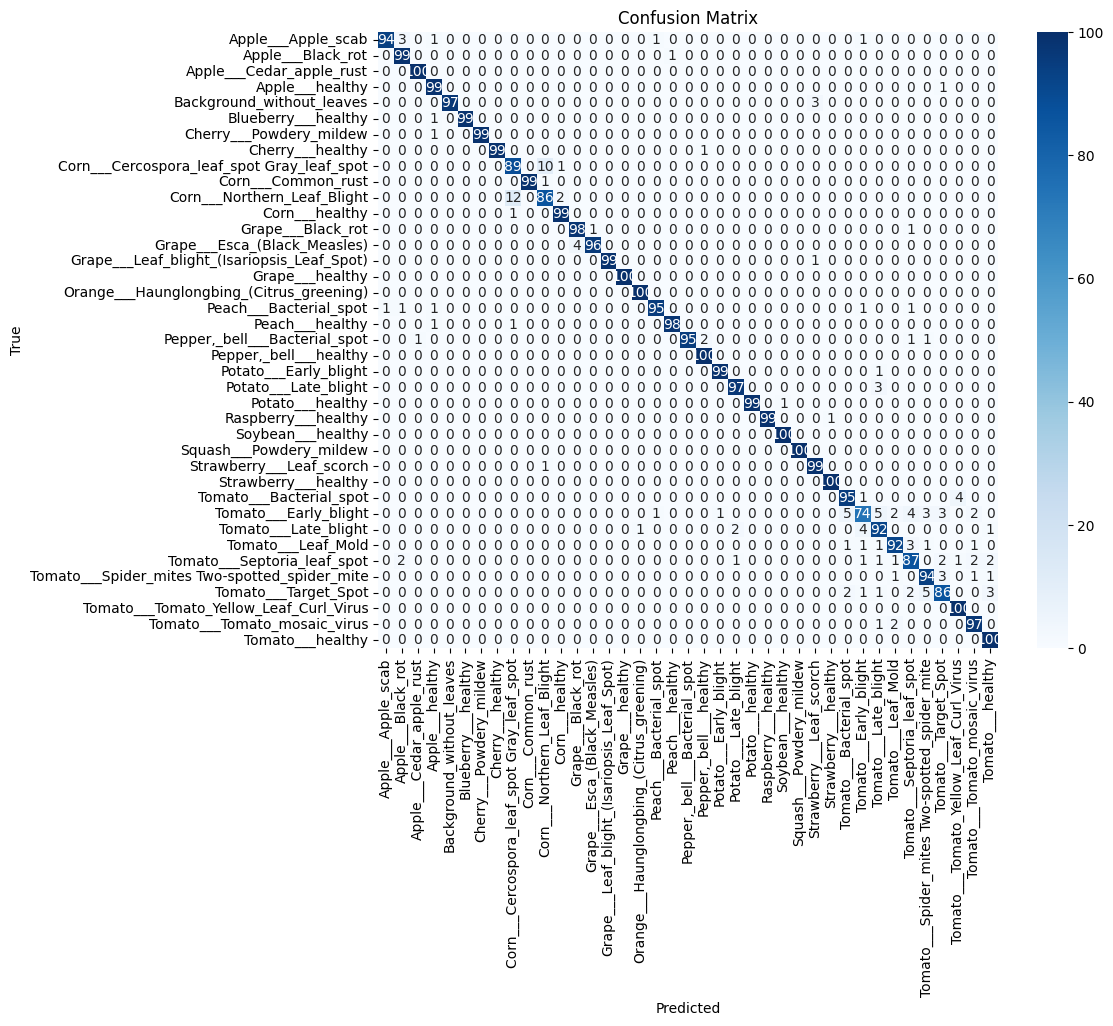

In [18]:
# Run the training and evaluation
train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10, patience=3)
model.load_state_dict(torch.load('Resnet18_V1_model.pth'))  # Load the best model
test_loss, test_acc, all_labels, all_predictions = evaluate_model(model, test_loader, criterion)
print(f"Test Loss: {test_loss:.6f}, Test Accuracy: {test_acc:.2f}%")

Test Loss: 0.122563, Test Accuracy: 96.15%


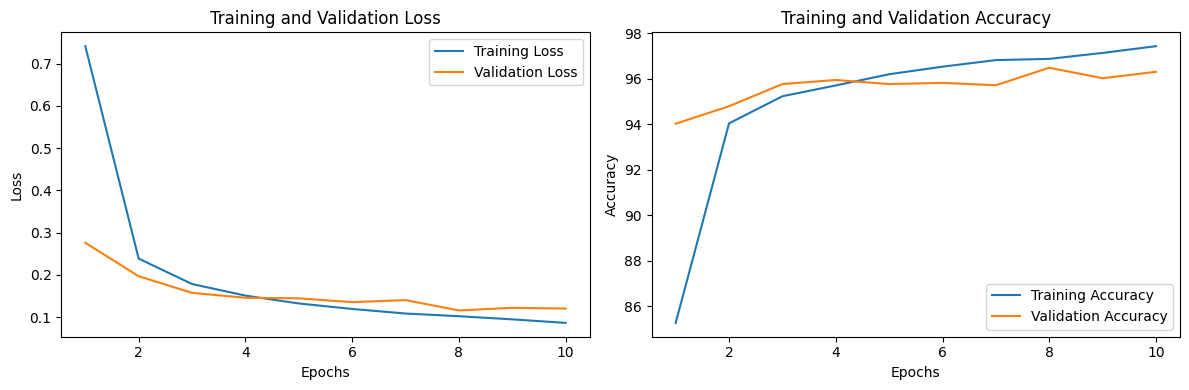

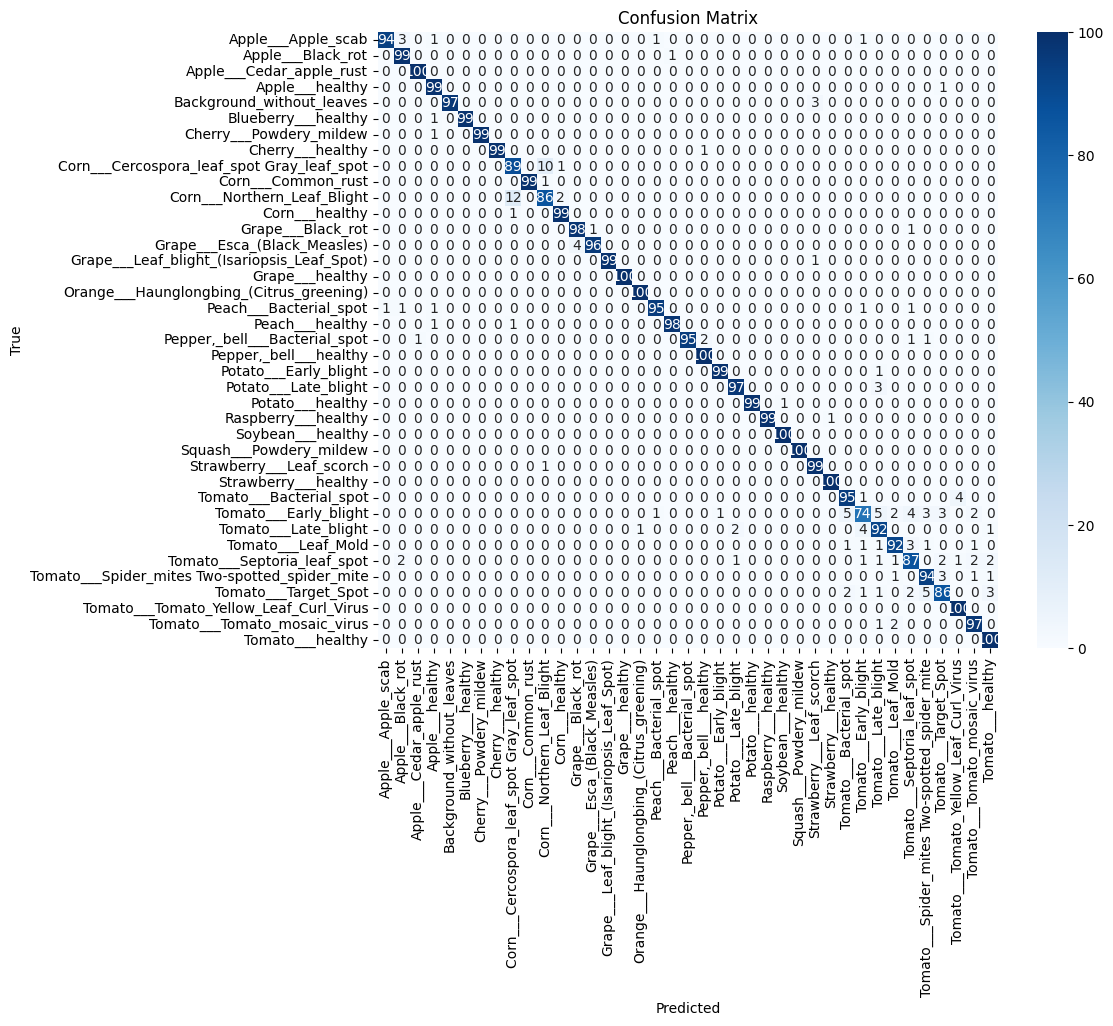

In [19]:
# Plot metrics and confusion matrix
plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies)
plot_confusion_matrix(all_labels, all_predictions, train_data.classes)

In [20]:
# Save the model, optimizer, and other components
checkpoint = {
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'train_transforms': train_transforms,
    'val_transforms': val_transforms,
    'test_transforms': test_transforms,
    'class_to_idx': train_data.class_to_idx,
    'num_classes': num_classes
}
torch.save(checkpoint, '/content/drive/My Drive/model_pth/PlantVillage_CNN_checkpoint_Resnet18_V2.pth')
